### Introduction to Data Science
## Homework 3: Due 5pm to My Mailbox (2nd Floor, 19 W 4th St) Wednesday April 19th

    Student Name: Ruojun Hong

    Student Netid: rh2544
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
def cleanBosonData(infile_name):
    data = pd.read_csv(infile_name, sep = ',')
    # create a feature Y with numeric label
    major_value = data['Label'].value_counts().idxmax()
    data['Y'] = (data['Label'] != major_value).astype(int)
    # drop the feature Label
    data = data.drop('Label',1)
    # create dummy variable for missing value
    for column in data:
        data = data.replace(to_replace={column:{-999: np.nan}})
        if(pd.isnull(data[column]).sum() > 0):
            data[column+"_mv"] = (data[column].isnull()).astype(int)
    # Replace missing value with the average of the feature
    for column in data:
        data = data.replace(to_replace={column:{np.nan: data[column].mean()}}) 
    #normalize
    data = pd.DataFrame(preprocessing.scale(data),columns=data.columns)
    data['Y'] = (data['Y'] >0).astype(int)
    return data

### Part 2: Basic evaluations
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [3]:
data_train = cleanBosonData("data/boson_training_cut_2000.csv")
data_test = cleanBosonData("data/boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

0.75717137493836262

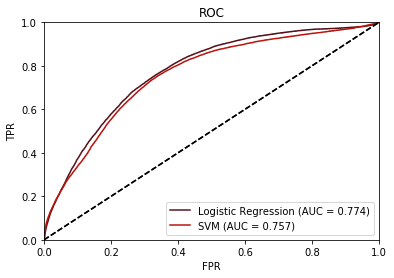

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
%matplotlib inline

#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

#Split sets
Y_train = data_train['Y']
X_train = data_train.drop('Y',1)
Y_test = data_test['Y']
X_test = data_test.drop('Y',1)

#Logistic Regression
lr = LogisticRegression(C=1e30)
lr.fit(X_train,Y_train)
lr_predict= lr.predict_proba(X_test)[:,1]
plotUnivariateROC(lr_predict, Y_test, "Logistic Regression")

#SVM
svm = SVC(kernel="linear",probability=True)
svm.fit(X_train,Y_train)
svm_predict = svm.predict_proba(X_test)[:,1]
plotUnivariateROC(svm_predict, Y_test, "SVM")

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Generally Logistic Regression performs better. From the curve we can tell that, approximately when TPR is between 0-0.8,FPR is between0-0.3, Logistic Regression outperforms SVM more and more.

### Part 3: Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [5]:
# Code here
from sklearn.metrics import roc_auc_score
def xValSVM(dataset, label_name, k, cs): 
    aucs={}
    for c in cs:
        aucs[c]=[]
    for f in range(k):
        fra=f+2
        data_validate=dataset.sample(frac=1/fra)
        data_train= dataset.loc[~dataset.index.isin(data_validate.index)]
        for c in cs:
            Y_train=data_train['Y']
            X_train=data_train.drop('Y',1)
            Y_validate=data_validate['Y']
            X_validate=data_validate.drop('Y',1)
            svm = SVC(kernel="linear",probability=True,C=c)
            svm.fit(X_train,Y_train)
            svm_predict = svm.predict_proba(X_validate)[:,1]
            auc=roc_auc_score(Y_validate,svm_predict)
            aucs[c].append(auc)
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [6]:
#Code here
cs =[10**-8,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1]
dict_score=xValSVM(data_train,'Y',10, cs)

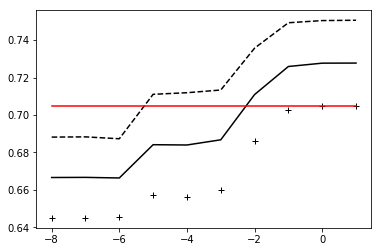

In [9]:
keys=[]
means=[]
stderrs=[]
diffs=[]
sums=[]
maxdiffs=[]
for key in dict_score:
    mean=np.mean(dict_score[key])
    std=np.std(dict_score[key])
    keys.append(key)
    means.append(mean)
    stderrs.append(std)
    diffs.append(mean-std)
    sums.append(mean+std)

maxdiff=np.max(diffs)
for key in keys:
    maxdiffs.append(maxdiff)

plt.plot(np.log10(keys),means,'k')
plt.plot(np.log10(keys),diffs,'k+')
plt.plot(np.log10(keys),sums,'k--')
plt.plot(np.log10(keys),maxdiffs,'r')
plt.show()

answer here: No.

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


answer here: Logistic Regression is more suitable. And it was not worthy.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?
answer here: The bigger the size of the training set is, the larger the error is.


answer here: The bigger the size of the training set is, the larger the error is.